# Recipe Review Sentiment Analysis Part 2: A Baseline Model 2.1 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chillyssa/NLP-with-Deep-Learning-Project/blob/main/project_part2-1.ipynb)

In my previous notebook [Recipe Review Analysis Part 2: A Baseline Model](https://colab.research.google.com/github/chillyssa/NLP-with-Deep-Learning-Project/blob/main/project_part2.ipynb) I continued my NLP sentiment analysis experiment with [recipe review data](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions) from Food.com's online recipe generator. 

The original data set comes from Kaggle and was originally gathered for the below cited research. 

Generating Personalized Recipes from Historical User Preferences
Bodhisattwa Prasad Majumder*, Shuyang Li*, Jianmo Ni, Julian McAuley
EMNLP, 2019
https://www.aclweb.org/anthology/D19-1613/

## What Happened? 

My baseline model performed terribly, 48.82% accuracy on my final test data to be exact. There were two major issues with this baseline model that I have chosen to address here in this notebook, calling it a 2.1 version baseline model before moving on to my ultimate goal of using a deep learning model for sentiment analysis. 

### Issue 1: The 0 Ratings Category
During my initial EDA in [Recipe Review Analysis Part I](https://colab.research.google.com/github/chillyssa/NLP-with-Deep-Learning-Project/blob/main/project_part1.ipynb) I discovered that the polarity of the 0 rating category was much higher than I would have expected it to be. From there, I should have looked at the reviews of the 0 ratings a little bit more. Had I done so, I would have discovered that many of the 0 ratings are actually very postive ratings. What I attribute this to is a user leaving a review but not a rating, so the rating is automatically set to 0. For the purposes of this experiment I am opting to remove the reviews with a 0 rating from my data set and only use ratings 1-5. 

### Issue 2: Incorrect use of vectorizer 
Initially I was getting different shapes of the one-hot-vector for `X_train`, `X_val` and `X_test`. I found a work around by using the `max_features` parameter to ensure the model would fit to all three data sets. This "work around" is actually incorrect. I mistakenly was using the vectorizer’s `fit_transform()` method for `X_train`, `X_val` and `X_test`. The `fit_transform()` method is to be used when the vocabulary is first created one time with the training data. The validation and test data should use the `transform()` method. Credit and Kudos to [Dr. Steve Geinitz](https://github.com/sgeinitz) for helping me see the error of my ways here! 





In [ ]:
# mount google drive to import data files - only have to run this once. 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing python modules/packages to be utilized 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import log_loss

# Trying different models and using the best fit 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier


# importing data set with pandas
pd.set_option('display.max_colwidth', 0)
train_path = '/content/drive/MyDrive/NLP-F22/data/pp_train.csv'
df_train = pd.read_csv(train_path,index_col=0)
df_train['tokens'] = df_train['p_review'].str.lower().str.split()

# Remove 0 ratings from trainging data set 
df_train = df_train[df_train['rating'] != 0]
review_ratings = df_train['rating'].value_counts()
print(review_ratings)
df_train.head()

,user_id,recipe_id,date,rating,review,review_len,word_count,p_review,tokens
0,384043,19023,2008-06-20,5,Oh So good!!!!!!! Thank you for the great recipe. It was the first time I've ever made my own sauce and I was so proud.,122,25,oh good thank great recipe first time ive ever made sauce proud,"[oh, good, thank, great, recipe, first, time, ive, ever, made, sauce, proud]"
1,1127316,51803,2009-01-12,0,"This is a great soup. Only, watch out for the flavor packet that it comes with. It contains MSG, under the name of hydrolyzed soy protein (anything hydrolyzed or autolyzed contains free glutamate). It is a great soup without the flavor packet. Yum!",252,43,great soup watch flavor packet come contains msg name hydrolyzed soy protein anything hydrolyzed autolyzed contains free glutamate great soup without flavor packet yum,"[great, soup, watch, flavor, packet, come, contains, msg, name, hydrolyzed, soy, protein, anything, hydrolyzed, autolyzed, contains, free, glutamate, great, soup, without, flavor, packet, yum]"
2,1872570,89207,2011-04-02,0,Haven't made this yet but just wanted to let HeyLillie know that I printed the recipe and it was correct. No weird mixup on the measurements. Perhaps your printer had a glitch. That said I am anxious to try this frosting on a ho ho cake. Will post after that.,264,50,havent made yet wanted let know printed recipe correct weird mixup measurement perhaps printer glitch said anxious try frosting ho ho cake post,"[havent, made, yet, wanted, let, know, printed, recipe, correct, weird, mixup, measurement, perhaps, printer, glitch, said, anxious, try, frosting, ho, ho, cake, post]"
3,278578,106627,2008-01-25,5,great recipe! very easy and tasty. my very picky toddler could not get enough of it so that makes it a keeper!,110,22,great recipe easy tasty picky toddler could get enough make keeper,"[great, recipe, easy, tasty, picky, toddler, could, get, enough, make, keeper]"
4,235493,28559,2005-09-30,5,"Once again, another fantastic recipe from this cook. My lasagna never quite turns out right but this was perfect! Even my picky hubby loved it. The only difference was I used ricotta instead of cottage cheese but actually I think next time I might go ahead and use cottage cheese. This was great! I can't wait to make it again. Thank you so much for posting this. You are a fantastic cook!",396,72,another fantastic recipe cook lasagna never quite turn right perfect even picky hubby loved difference used ricotta instead cottage cheese actually think next time might go ahead use cottage cheese great cant wait make thank much posting fantastic cook,"[another, fantastic, recipe, cook, lasagna, never, quite, turn, right, perfect, even, picky, hubby, loved, difference, used, ricotta, instead, cottage, cheese, actually, think, next, time, might, go, ahead, use, cottage, cheese, great, cant, wait, make, thank, much, posting, fantastic, cook]"


## Splitting Data and Tokenization 
I want to extract the training data we are focusing on which is the recipe reviews(input features) and the rating(targets/labels). Note that we do already have a column feature of `tokens` that I created from `p_review` in my previous notebook, however I am going to instead tokenize `p_review` using Scikit-learn's `CountVectorizer` class. This will transform my `p_review` text into a matrix of token counts. I will use this later with the test/validation data as well. 

Additionally, I will split the training data furhter into training data and validation data to avoid data leakage while training the base model. I will use 80% of the data for training and 20% for validation. 

In [ ]:
# X will hold our processed review text and y will hold the rating which is our label/target value. 
X = df_train['p_review'].copy().astype('U')
y = df_train['rating'].copy().astype('U')

# split data into train and validation sets: df_train and df_val
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

# tokenize p_review into a matrix for X_train and X_val
one_hot_vectorizer = CountVectorizer(binary=True)
X_train = one_hot_vectorizer.fit_transform(X_train_raw)
X_val = one_hot_vectorizer.transform(X_val_raw)

# tfidf_vectorizer = TfidfVectorizer()
# X_train = tfidf_vectorizer.fit_transform(X_train_raw).toarray()
# X_val = tfidf_vectorizer.fit_transform(X_val_raw).toarray()

print(f"X_train.shape = {X_train.shape}")
print(f"X_val.shape = {X_val.shape}")
type(X_train)
type(X_val)

X_train.shape = (166302, 28261)
X_val.shape = (41576, 28261)


scipy.sparse.csr.csr_matrix

## The Baseline Model 2.1 

We have removed all the 0 ratings and fixed the methods used on our vectorizer so now we can use the tokens build a new baseline model that hopefully performs better than part 2! I am going to use the exact same model as before, the [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). I will first start with the training data and then move to the validation data. Then I will execute a funciton for hyperparameter tuning to see if we can increase accuracy! 

### Random Forest

Random Forest accuracy (on X_train): 0.9959


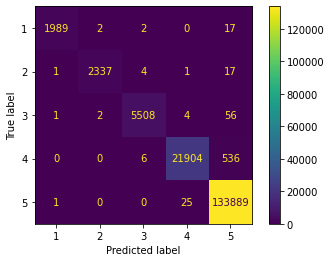

In [ ]:
#init a model using scikit-learn's RandomForestClassifier model 
rf_model = RandomForestClassifier(n_estimators=25)

#Fit the model to the training data, 
rf_model = rf_model.fit(X_train, y_train)
rf_predictions_train = rf_model.predict(X_train)

rf_display = ConfusionMatrixDisplay(confusion_matrix(y_train, rf_predictions_train), display_labels=['1', '2','3','4','5'])
rf_display.plot()
print(f"Random Forest accuracy (on X_train): {accuracy_score(y_train, rf_predictions_train):.4f}")

#### Fitting Random Forest to the Validation Data 

In [ ]:
#tokenizing p_review on validation data 
X_val = one_hot_vectorizer.transform(X_val_raw)
print(f"X_val.shape = {X_val.shape}")
type(X_val)

X_val.shape = (41576, 28261)


scipy.sparse.csr.csr_matrix

accuracy (on X_train): 0.8103


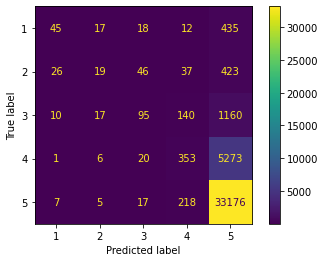

In [ ]:
rf_predictions_val = rf_model.predict(X_val)
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, rf_predictions_val), display_labels=['1', '2','3','4','5'])
disp.plot()
print(f"accuracy (on X_train): {accuracy_score(y_val, rf_predictions_val):.4f}")

#### Tuning a Hyperparameter 

In [ ]:
rf_tune = True # change this to False once hyperparam value is set 

# A function to create and fit a RF with a specific number of trees
def rf_tune_model(hyperparam_value):
    rf_model = RandomForestClassifier(n_estimators=hyperparam_value, random_state=5)
    rf_model.fit(X_train, y_train)
    y_train_pred_prob = rf_model.predict_proba(X_train)
    y_train_pred = rf_model.predict(X_train)
    y_val_pred_prob = rf_model.predict_proba(X_val)
    y_val_pred = rf_model.predict(X_val)
    train_loss = log_loss(y_train, y_train_pred_prob, labels=['1','2','3','4','5'])
    train_acc = accuracy_score(y_train, y_train_pred)
    val_loss = log_loss(y_val, y_val_pred_prob, labels=['1','2','3','4','5'])
    val_acc = accuracy_score(y_val, y_val_pred)
    return (train_loss, val_loss, train_acc, val_acc)

# Possible values for the hyperparameter are in the range of 5 to 150 (by 50)
hyp_param_vals = list(range(10,261,50)) # good values for n_estimators

metrics = []

if rf_tune:
    for hp in hyp_param_vals:
        metrics.append(rf_tune_model(hp))

##### Model Performance Results for Hyperparameter Tuning 

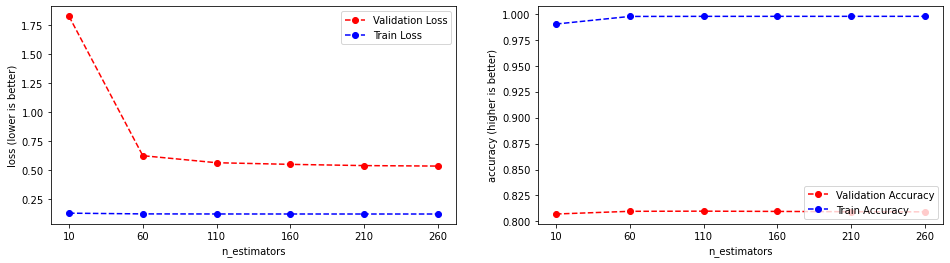

In [ ]:
# plot the results of each hyperparameter value specified in rf_tune_model 
if rf_tune:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    ax1.set_xticks(hyp_param_vals)
    ax1.set(xlabel="n_estimators", ylabel="loss (lower is better)")
    ax1.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validation loss
    ax1.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
    ax1.legend(["Validation Loss", "Train Loss"], loc=1)

    ax2.set_xticks(hyp_param_vals)
    ax2.set(xlabel="n_estimators", ylabel="accuracy (higher is better)")
    ax2.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validation accuracy
    ax2.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
    ax2.legend(["Validation Accuracy", "Train Accuracy"], loc=4)

In [ ]:
# a data frame containing hyperparam values, second row containing validation loss, third row containing validation accuracy

if rf_tune_model:
  tuning_data = {'Hyperparameter Values': hyp_param_vals, 
                 'Log Loss': [round(metric[1],2) for metric in metrics], 
                 'Accuracy Score': [round(metric[3],2) for metric in metrics]}
  tuning_results = pd.DataFrame(tuning_data)
  print(tuning_results)

   Hyperparameter Values  Log Loss  Accuracy Score
0  10                     1.83      0.81          
1  60                     0.63      0.81          
2  110                    0.57      0.81          
3  160                    0.55      0.81          
4  210                    0.54      0.81          
5  260                    0.54      0.81          


## Test Data 

In [ ]:
test_path = '/content/drive/MyDrive/NLP-F22/data/pp_test.csv'
df_test = pd.read_csv(test_path, index_col=0)

# Remove 0 ratings from test data set 
df_test = df_test[df_test['rating'] != 0]
review_ratings = df_test['rating'].value_counts()
print(review_ratings)


X_test = one_hot_vectorizer.transform(df_test['p_review'].astype('U'))
y_test = df_test['rating'].copy().astype('U')
print(f"X_test.shape = {X_test.shape}")
print(type(X_test))
df_test.head()

5    43032
4    6844 
3    1812 
2    760  
1    676  
Name: rating, dtype: int64
X_test.shape = (53124, 28261)
<class 'scipy.sparse.csr.csr_matrix'>


,user_id,recipe_id,date,rating,review,p_review,tokens
592612,764278,32614,2012-12-22,5,I made these last night for a Christmas caroling party and they were devoured. Amazing and simple! Thanks for the recipe!,i made last night christmas party devoured amazing simple thanks recipe,"['i', 'made', 'last', 'night', 'christmas', 'party', 'devoured', 'amazing', 'simple', 'thanks', 'recipe']"
469583,2039663,29679,2012-01-24,5,"Very rich and does taste very similar to Reese's. Made half a batch and probably would have been enough for 10 people. There were 4 adults in the party and we had 3/4 of it left not because of the taste but because of the richness. Next time I will try it in mini muffin cups. Although my husband loves Reese's, he didn't care too much for these (maybe the richness was too much for him?). Thanks for sharing!",very rich taste similar reeses made half batch probably would enough 10 people there 4 adult party 3 4 left taste richness next time i try mini muffin cup although husband love reeses didnt care much maybe richness much thanks sharing,"['very', 'rich', 'taste', 'similar', 'reeses', 'made', 'half', 'batch', 'probably', 'would', 'enough', '10', 'people', 'there', '4', 'adult', 'party', '3', '4', 'left', 'taste', 'richness', 'next', 'time', 'i', 'try', 'mini', 'muffin', 'cup', 'although', 'husband', 'love', 'reeses', 'didnt', 'care', 'much', 'maybe', 'richness', 'much', 'thanks', 'sharing']"
329767,1597075,59311,2012-05-22,5,Great pork chops.My husband and 4 year old daughters favorite,great pork husband 4 year old daughter favorite,"['great', 'pork', 'husband', '4', 'year', 'old', 'daughter', 'favorite']"
161447,880806,10125,2009-10-23,5,These cookies ROCK! I did them with M & M's and chocolate pudding...I was a hero in my house!,these cooky rock i m ms chocolate hero house,"['these', 'cooky', 'rock', 'i', 'm', 'ms', 'chocolate', 'hero', 'house']"
993644,155943,54677,2006-10-09,5,"Very good, very easy. I used potato bread for mine. :)",very good easy i used potato bread mine,"['very', 'good', 'easy', 'i', 'used', 'potato', 'bread', 'mine']"


In [ ]:
# Re-init a model using scikit-learn's RandomForestClassifier model 
rf_model = RandomForestClassifier(n_estimators=110)

# Re-fit the model to the training data
rf_model = rf_model.fit(X_train, y_train)


Random Forest accuracy (on X_test): 0.8170


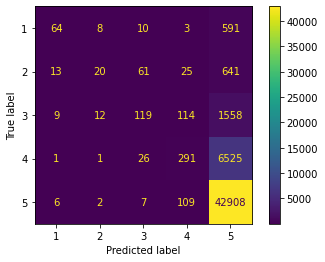

In [ ]:
# Now make predictions on the test data 
rf_predictions_test = rf_model.predict(X_test)

# Display accuracy and confusion matrix 
rf_display = ConfusionMatrixDisplay(confusion_matrix(y_test, rf_predictions_test), display_labels=['1', '2','3','4','5'])
rf_display.plot()
print(f"Random Forest accuracy (on X_test): {accuracy_score(y_test, rf_predictions_test):.4f}")

## Conclusions 2.1

After removing the 0 rating reviews from both my training and test data as well as adjusting my training model to use the correct vectorizer methods, my training model performed much better. 81.7% vs. 48.82% accuracy is a significant improvement!! In the final part of this project I am going to be using a deep learning model with my data set to see if I can improve on my accuracy score at all! Stay tuned! 